In [1]:
import numpy as np
import matplotlib.pyplot as plt


from scipy import stats
from scipy.signal import find_peaks
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize

from collections import Counter
from itertools import product
from dataclasses import dataclass

from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import glob
import os

from datetime import datetime

A utility to get filenames time-date stamped

In [2]:
def get_unique_filename(fname):
    return fname.format(
        datetime.now().strftime("_%m-%d_%H-%M")
    )

# Loading and pre-processing pulses

In [3]:
folder_data = "03-09-2022"

os.listdir(folder_data)

['N0_F06_3.dat',
 'N0_F08_4.dat',
 'N0_F06_2.dat',
 'N0_F06_4.dat',
 'N0_F08_5.dat',
 'N0_F06_1.dat',
 'N0_F07_5.dat',
 'N0_F07_2.dat',
 'N0_F05_3.dat',
 'N0_F05_1.dat',
 'N0_F06_5.dat',
 'N0_F08_1.dat',
 'N0_F05_4.dat',
 'N0_F08_3.dat',
 'N0_F07_1.dat',
 'N0_F07_4.dat',
 'N0_F05_5.dat',
 'N0_F05_2.dat',
 'N0_F07_3.dat',
 'N0_F08_2.dat']

## Loading "pure" harmonics

In [4]:
pulses = {}

# declare type
@dataclass
class Pulse:
    time: np.ndarray
    field: np.ndarray
    _individual_fields: np.ndarray = None
    peaks_time: np.ndarray = None
    time_range: np.ndarray = None
    half_period: float = 0
    interp_field: InterpolatedUnivariateSpline = None
    err_lower_bound: InterpolatedUnivariateSpline = None
    err_upper_bound: InterpolatedUnivariateSpline = None
    
# save maximal amplitude of the field
max_ampl = []

for freq in range(5, 9):
    
    # load all pulses for the given frequency
    filenames = glob.glob(folder_data + '/N0_F0{}_*.dat'.format(freq))
    
    all_data = [np.loadtxt(_).T[:-1] for _ in filenames]
    
    times, _individual_fields = zip(*all_data)
    
    _individual_fields = np.array(_individual_fields)
    
    time = times[0]
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"

    #  Checking whether the time axis coincide
    assert all(np.allclose(time, _) for _ in times), \
        "This workbook cannot be used since the time data is not syncronized"
    
    label = '0.{} THz'.format(freq)
    print("{} files loaded for {}".format(len(filenames), label))

    
    field = np.mean(_individual_fields, axis=0)
    
    # Substract the mean from experimental fields to compensate for parasitic offset
    field -= field.mean()
    
    # calculate the confidence interval
    confidence_level = 0.95
    
    err_lower_bound, err_upper_bound = stats.t.interval(
        confidence_level, 
        _individual_fields.shape[0], 
        field, 
        stats.sem(_individual_fields - field, axis=0)
    )
    
    abs_field = np.abs(field)

    max_ampl.append(abs_field.max())
    
    # Extract information for the combinatorial method     
    ampl_threshold = 0.4 * abs_field.max()
    
    indx = find_peaks(abs_field, height=ampl_threshold)[0]
    peaks_time = time[indx[1:-1]]
    
    half_period = Counter(np.diff(peaks_time)).most_common(1)[0][0]
        
    # Saving the data 
    pulses[label] = Pulse(
        time = time, 
        field = field,
        _individual_fields = _individual_fields,
        peaks_time = peaks_time,
        time_range = time[indx[1]:indx[-2]],
        half_period = half_period,
        # first save confidence interval as arrays
        err_lower_bound = err_lower_bound,
        err_upper_bound = err_upper_bound,
    )
    
# saving the largest frequency
largest_freq = label

#  Checking whether the time axis coincide
assert all(np.allclose(time, data.time) for data in pulses.values()), \
    "This workbook cannot be used since the time data is not syncronized"

# saving time step
dtime = time[1] - time[0]

max_ampl = max(max_ampl)

# Normalazing fields and interpolating
for data in pulses.values():
    data.field /= max_ampl
    
    data.interp_field = UnivariateSpline(
        data.time, 
        data.field,
        ext='zeros', 
        k=3, 
        s=0
    )
    
    # interpolate confidence interval
    data.err_lower_bound = UnivariateSpline(
        data.time, 
        data.err_lower_bound / max_ampl, 
        ext='zeros', 
        k=3, 
        s=0
    )
    
    data.err_upper_bound = UnivariateSpline(
        data.time, 
        data.err_upper_bound / max_ampl, 
        ext='zeros', 
        k=3, 
        s=0
    )

5 files loaded for 0.5 THz
5 files loaded for 0.6 THz
5 files loaded for 0.7 THz
5 files loaded for 0.8 THz


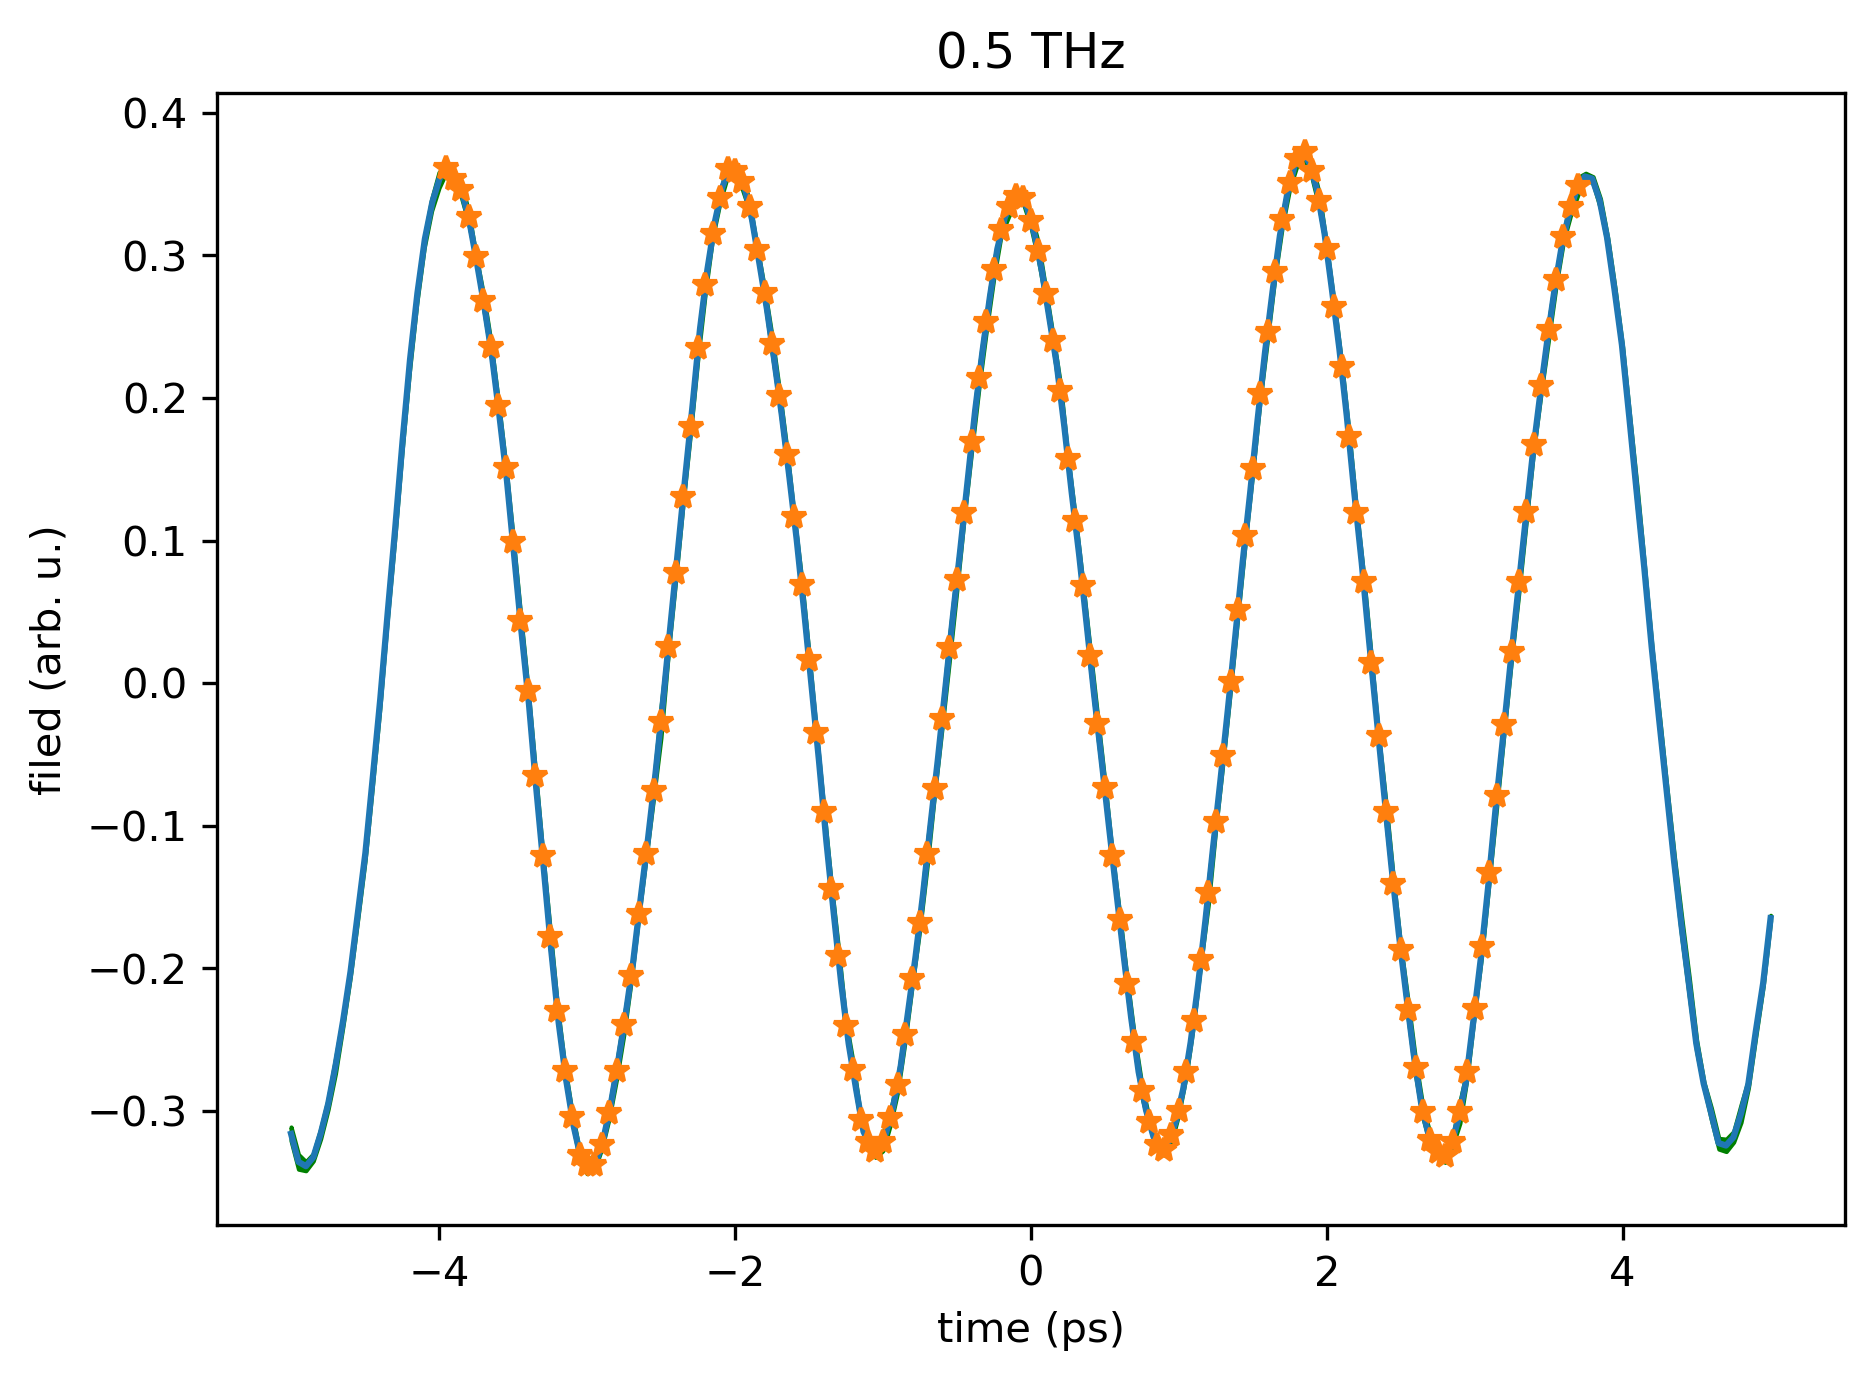

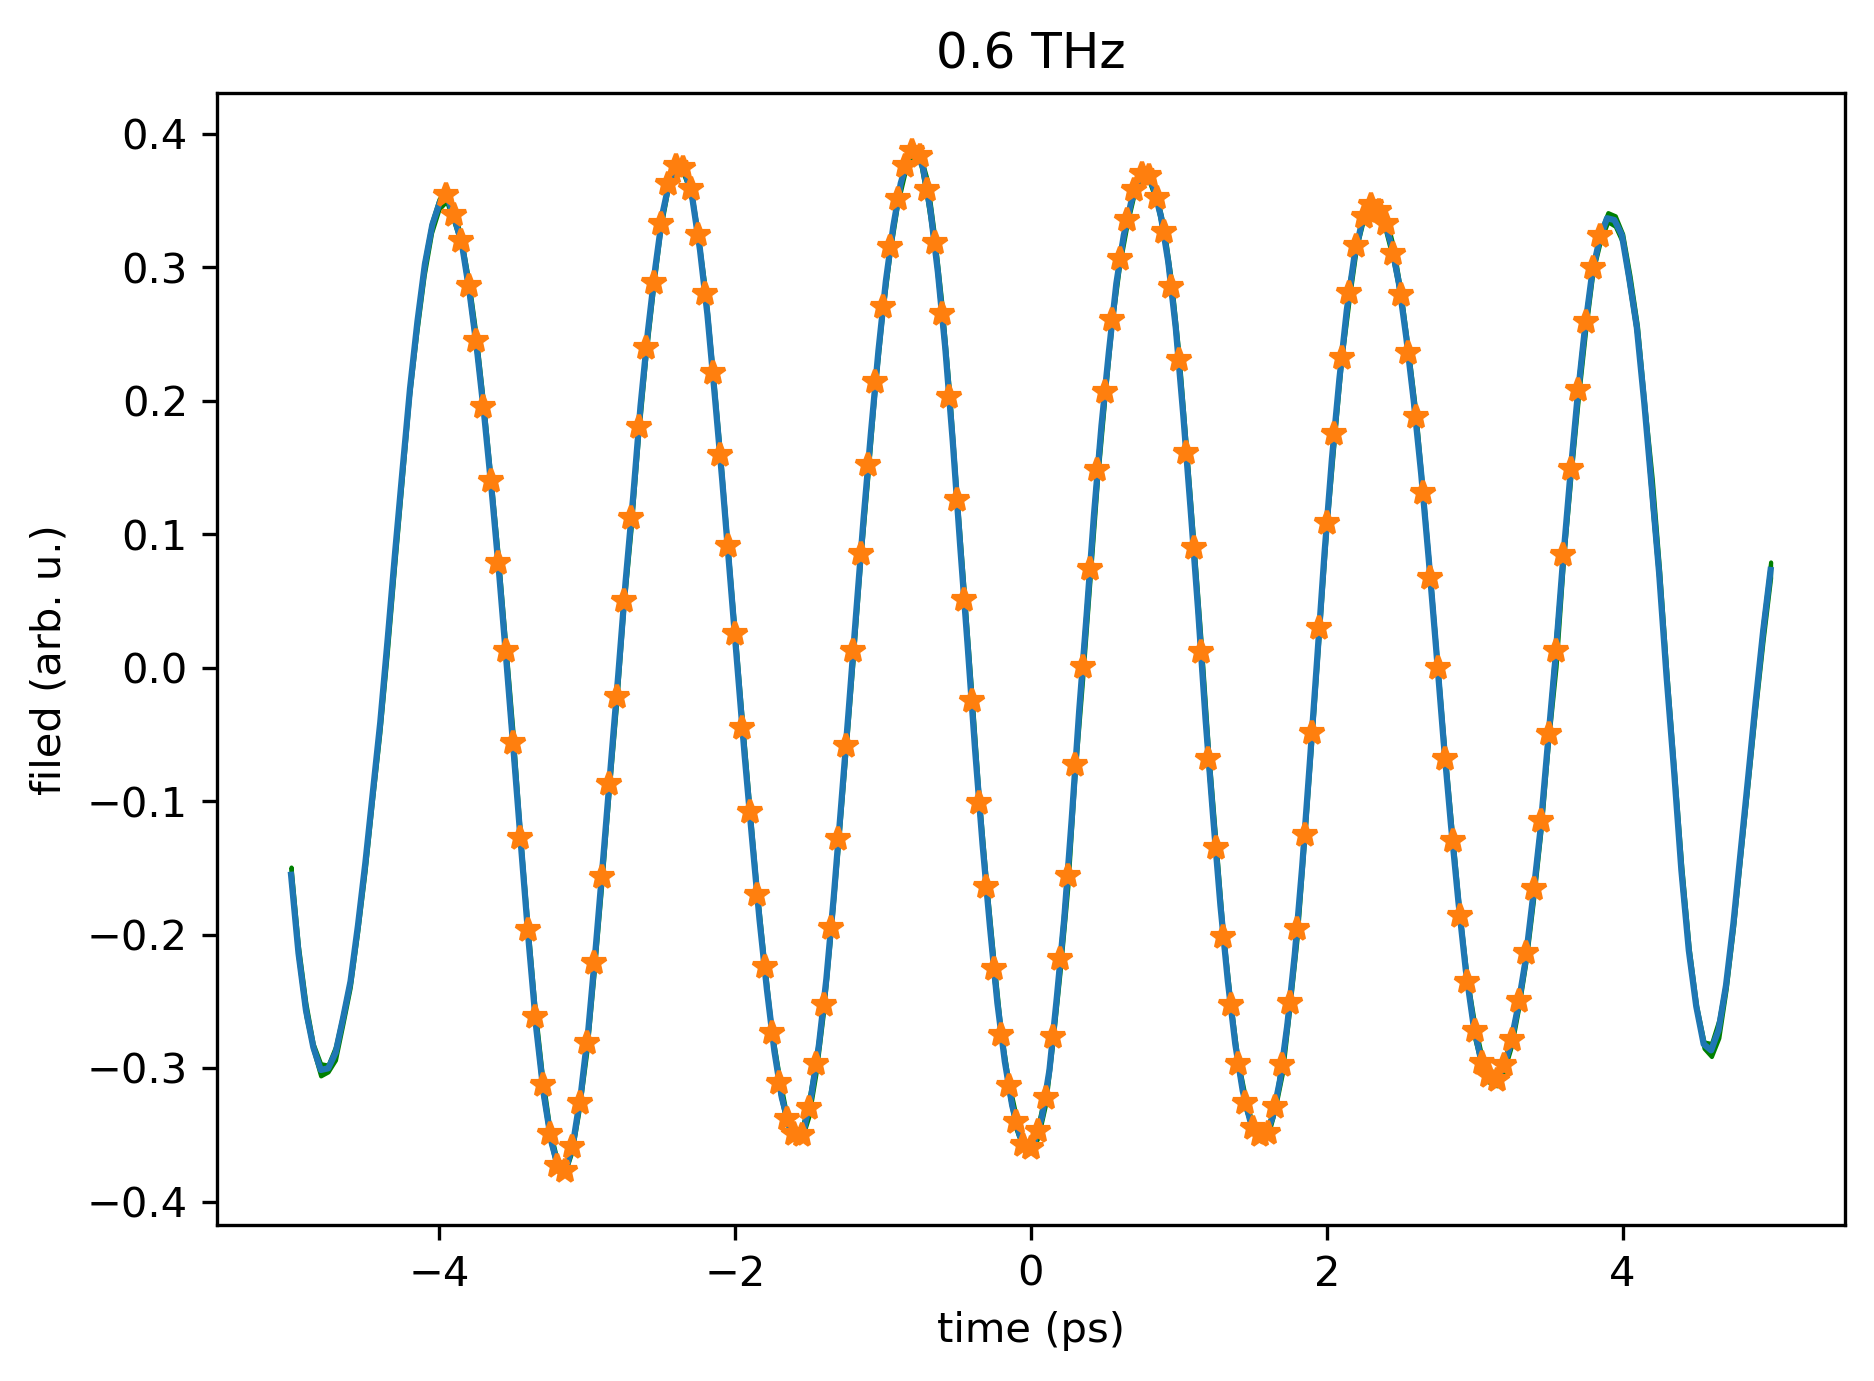

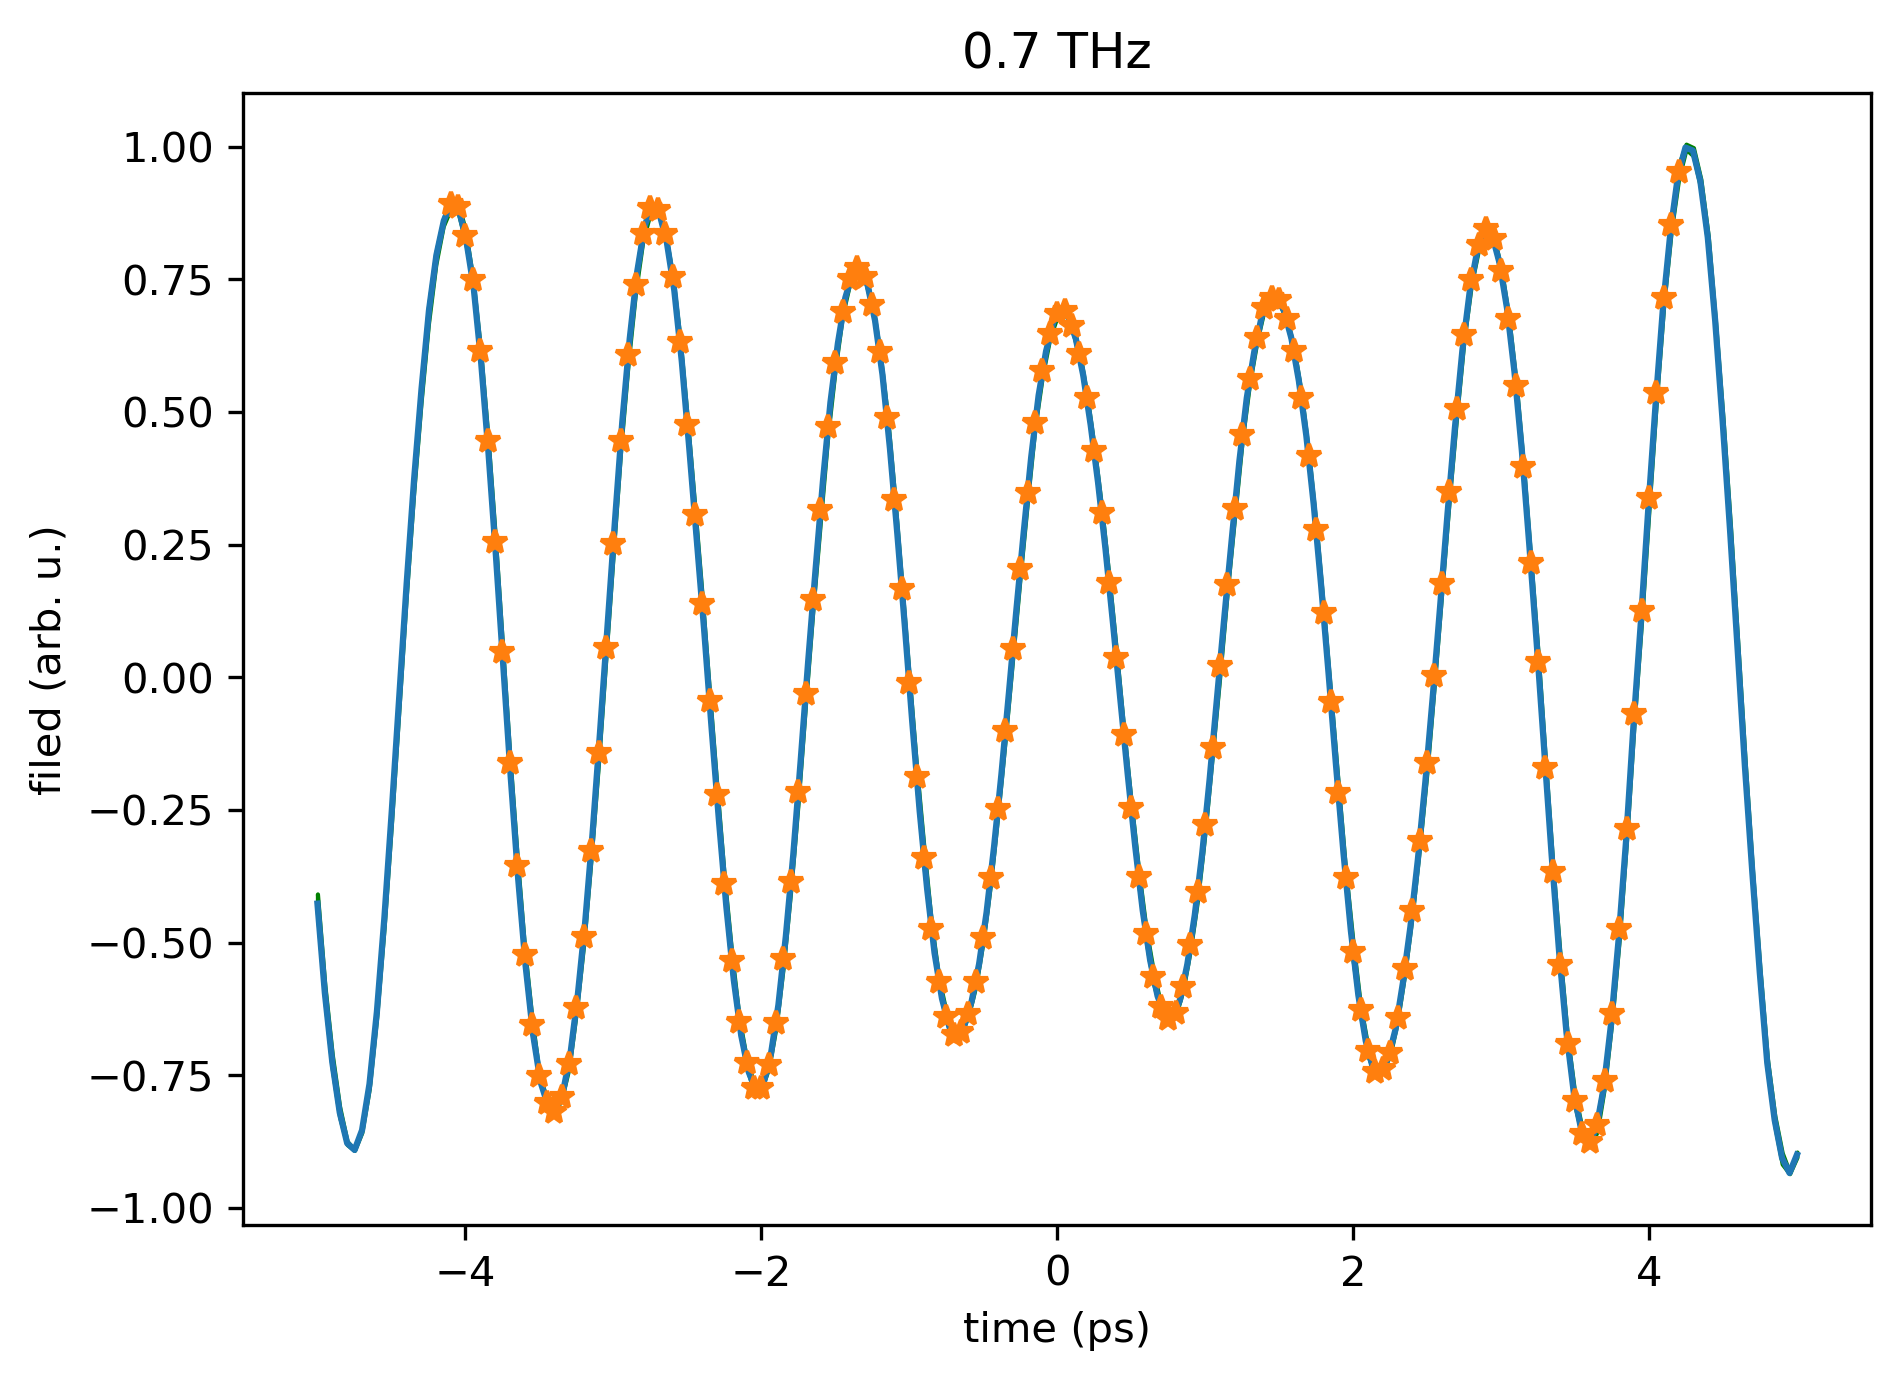

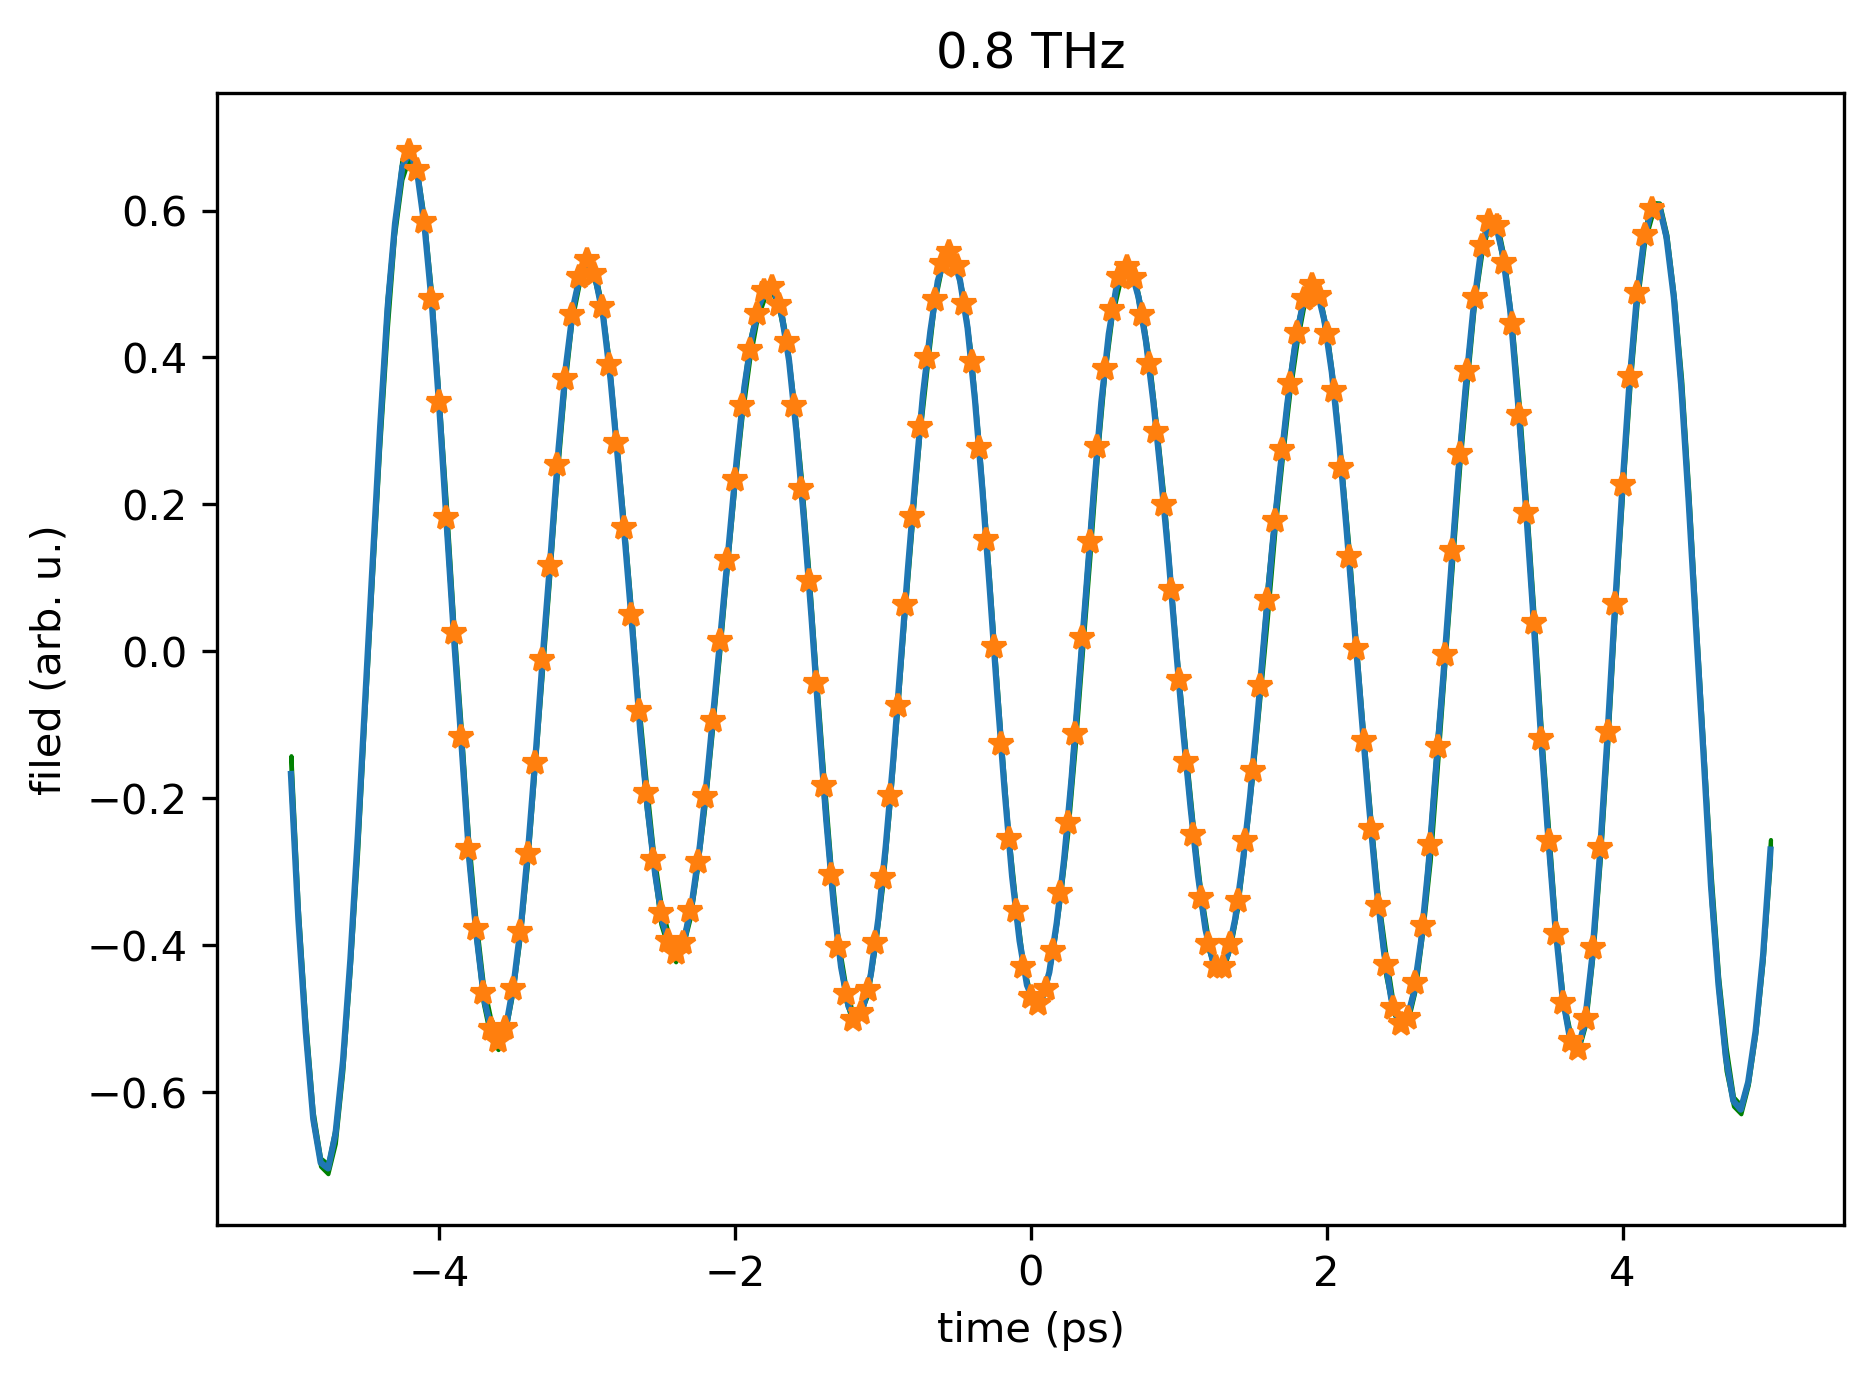

In [5]:
# Plot pulses
for freq, data in pulses.items():
    
    plt.figure(figsize=(7, 5), dpi=300)
    plt.title(freq)
    
    #plt.plot(data.time,  data.field, '.-')
        
    plt.fill_between(
        data.time, 
        data.err_lower_bound(data.time), 
        data.err_upper_bound(data.time),
        color='g',
        #alpha=0.2,
    )
    
    t = np.linspace(time.min(), time.max(), 200)
    plt.plot(t, data.interp_field(t))
    
    plt.plot(data.time_range, data.interp_field(data.time_range), '*')
    
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()  

### Manually extract observational time window 

0.6000000000000001


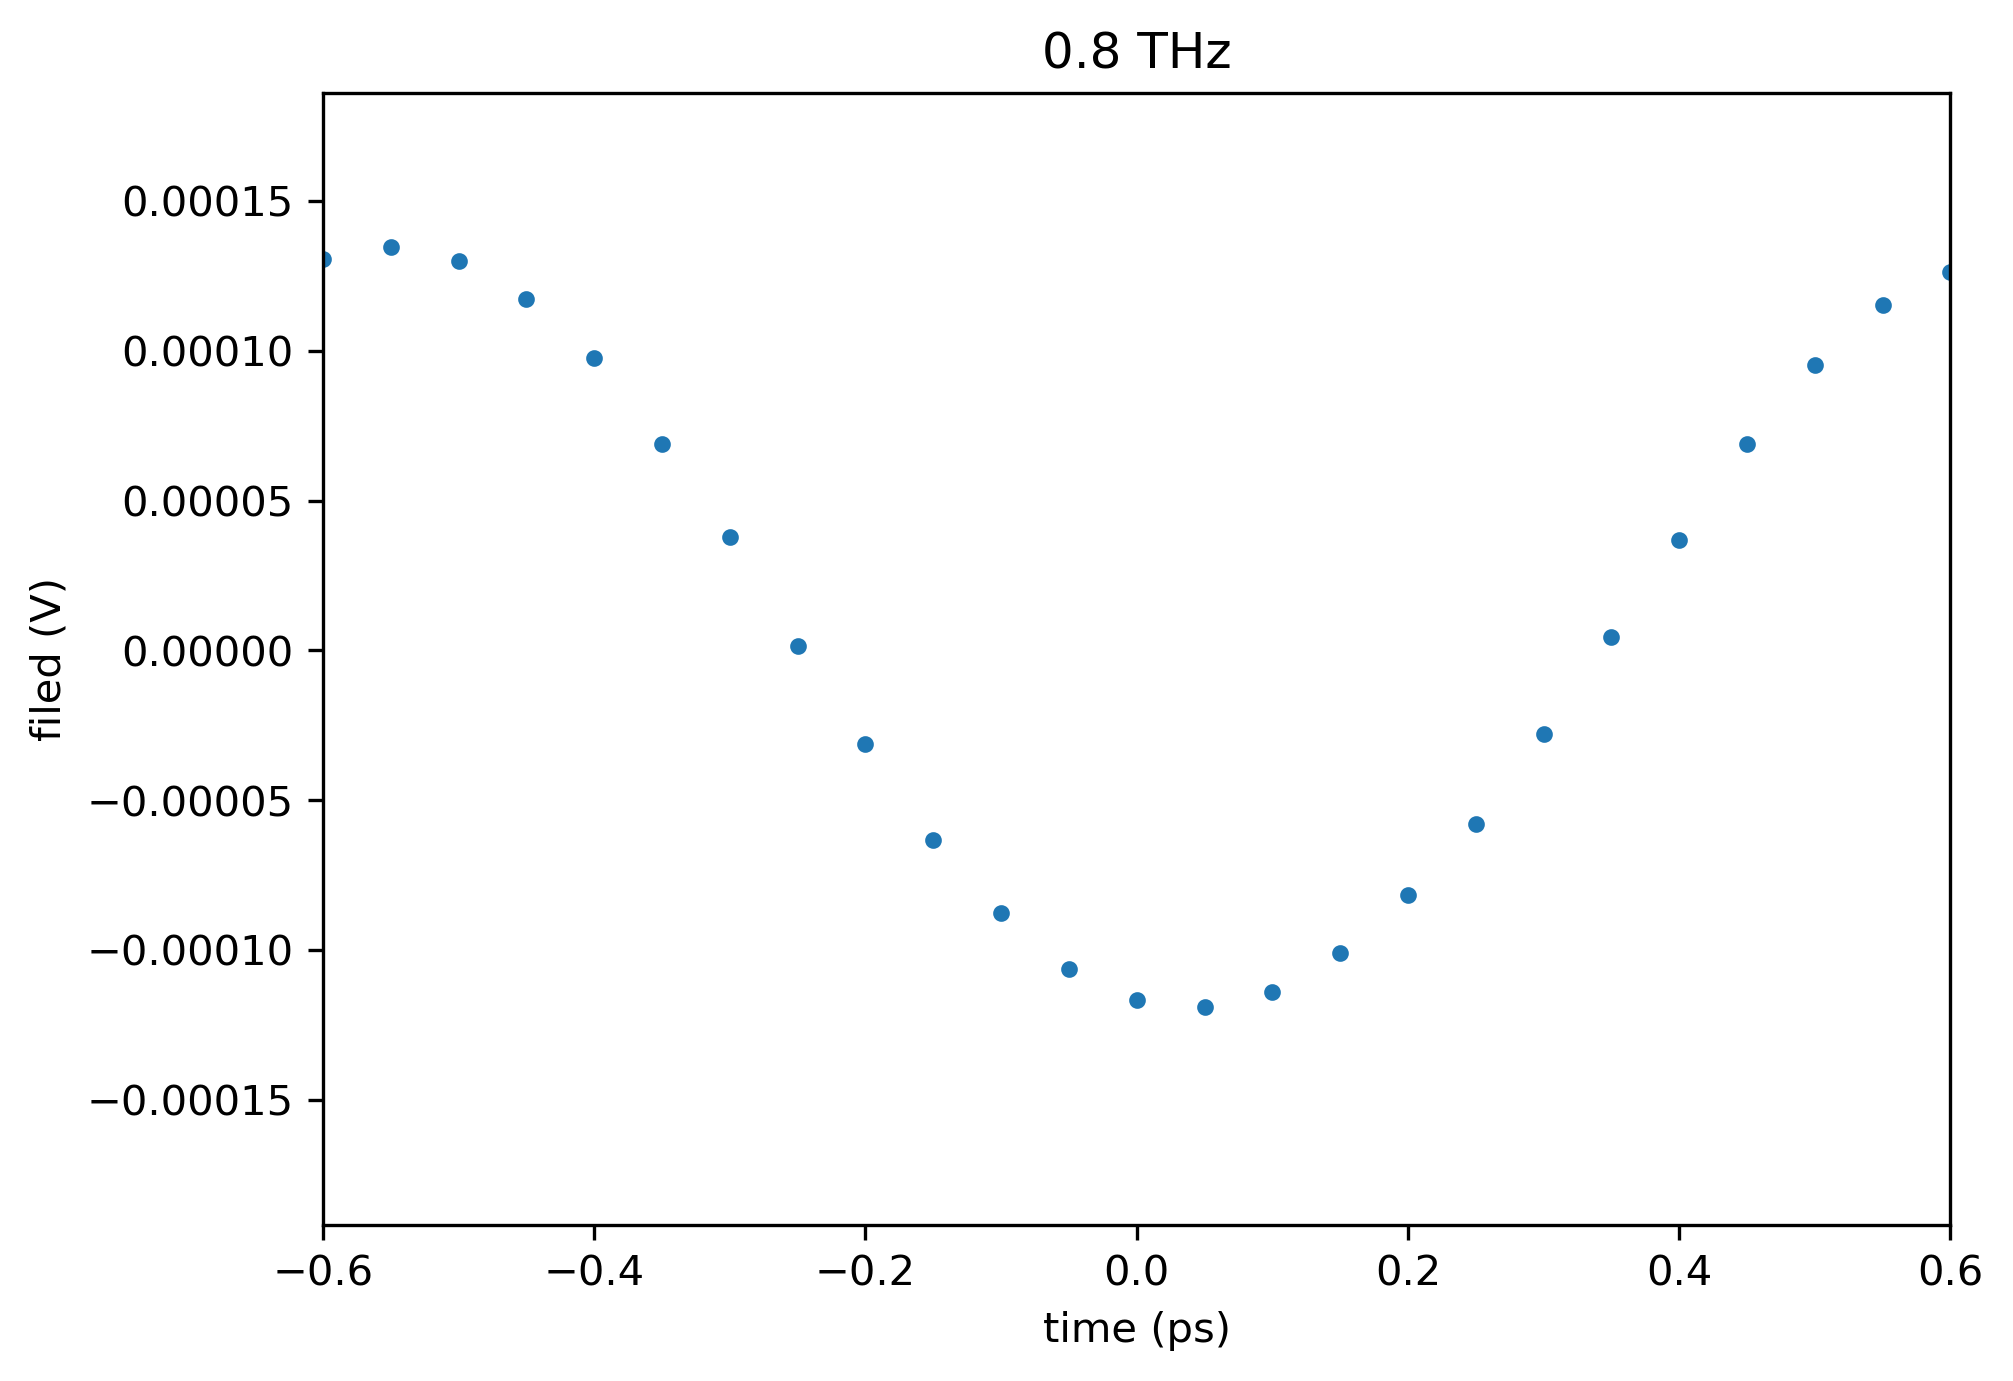

In [6]:
plt.figure(figsize=(7, 5), dpi=300)
    
field = pulses[largest_freq].field
half_period = pulses[largest_freq].half_period

print(half_period)

plt.plot(time, max_ampl * field, '.')

observational_window = -half_period, half_period

plt.xlim(observational_window)
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')
plt.title(largest_freq)    
plt.show()

### Plot all pulses within the observational window

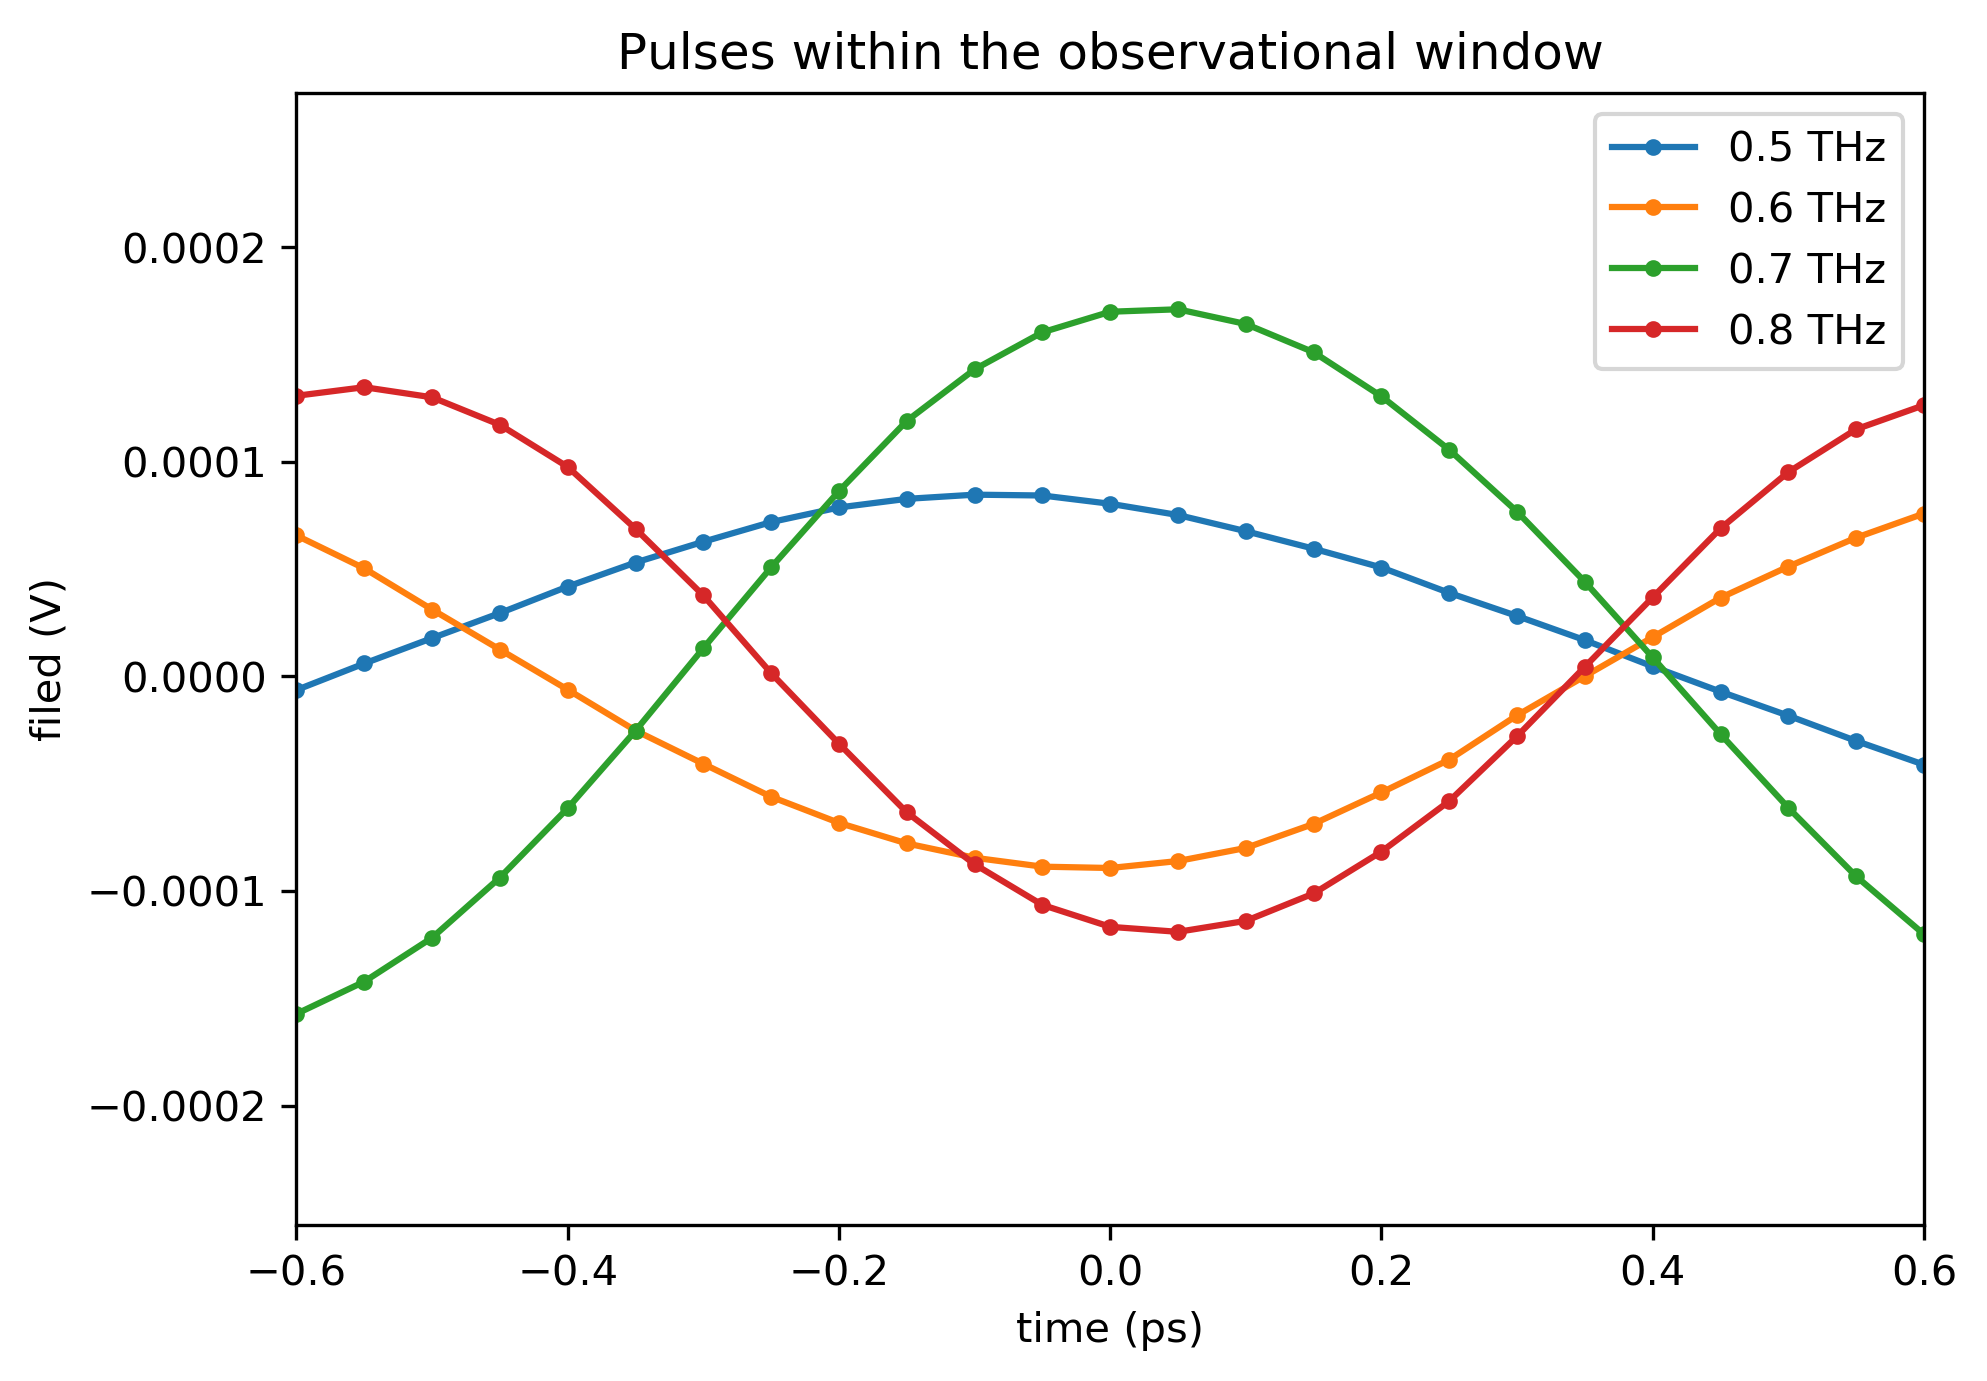

In [7]:
# Plot pulses
plt.figure(figsize=(7, 5), dpi=300)

plt.title("Pulses within the observational window")

for freq, data in pulses.items():
    plt.plot(data.time, max_ampl * data.field, '.-', label=freq)
    

#plt.plot(combined_pulse.time, combined_pulse.field, '.-', color='black', label='experimental pulse')
    
plt.xlim(np.array(observational_window))
plt.xlabel('time (ps)')
plt.ylabel('filed (V)')    

plt.legend()
plt.show()  

# Calculate superoscillations 

Time window for constructing superoscilations

In [8]:
half_period = pulses[largest_freq].half_period
time_window, dx = np.linspace(-half_period, half_period, 100, retstep=True)

time_window_raw = time[(time >= -half_period) & (time <= half_period)] 

## Get superoscilationsby using time delays only 

In [9]:
def get_combined_field(time_delays, time_window):
    return sum(
        _.interp_field(time_window - delay) for delay, _ in zip(time_delays, pulses.values())
    )

def inegral_without_ampl_modulation(time_delays):
    
    return simps(get_combined_field(time_delays, time_window) ** 2, dx=dx)

def jac_inegral_without_ampl_modulation(time_delays):
        
    E = get_combined_field(time_delays, time_window)
    
    return np.array([     
        -2. * simps(E * _.interp_field.derivative()(time_window - delay), dx=dx) 
        for delay, _ in zip(time_delays, pulses.values())
    ])

# Calculate superoscillations via Gradient descent 

Randomly generate the initial conditions

In [10]:
np.random.seed(3072022)

bounds = [(_.peaks_time.min(), _.peaks_time.max()) for _ in pulses.values()]

rand_initial_guess = np.array([
    np.random.uniform(_[0], _[1], 200 * cpu_count()) for _ in bounds
])

rand_initial_guess = set(tuple(_) for _ in rand_initial_guess.T)
len(rand_initial_guess)

22400

Perform an ensemble of bounded gradient decent minimizations

In [11]:
def local_minimization(initial_time_delays):
    result = minimize(
        inegral_without_ampl_modulation,
        initial_time_delays,
        #jac = jac_inegral_without_ampl_modulation,
        bounds=bounds,
        options={'maxiter': 1000},
    )
    
    # There is 2 decimal precision in the experiment 
    time_delays = np.round(result.x, 2)
    
    return inegral_without_ampl_modulation(time_delays), tuple(time_delays)

with Pool(cpu_count()) as pool:
    gradient_descent_results = set(pool.map(local_minimization, rand_initial_guess))

Post-process results

In [12]:
gradient_descent_results = sorted(gradient_descent_results)
intensity_without_ampl_modulation, all_time_delays = zip(*gradient_descent_results)

Extract the best candidates for getting superoscilations  

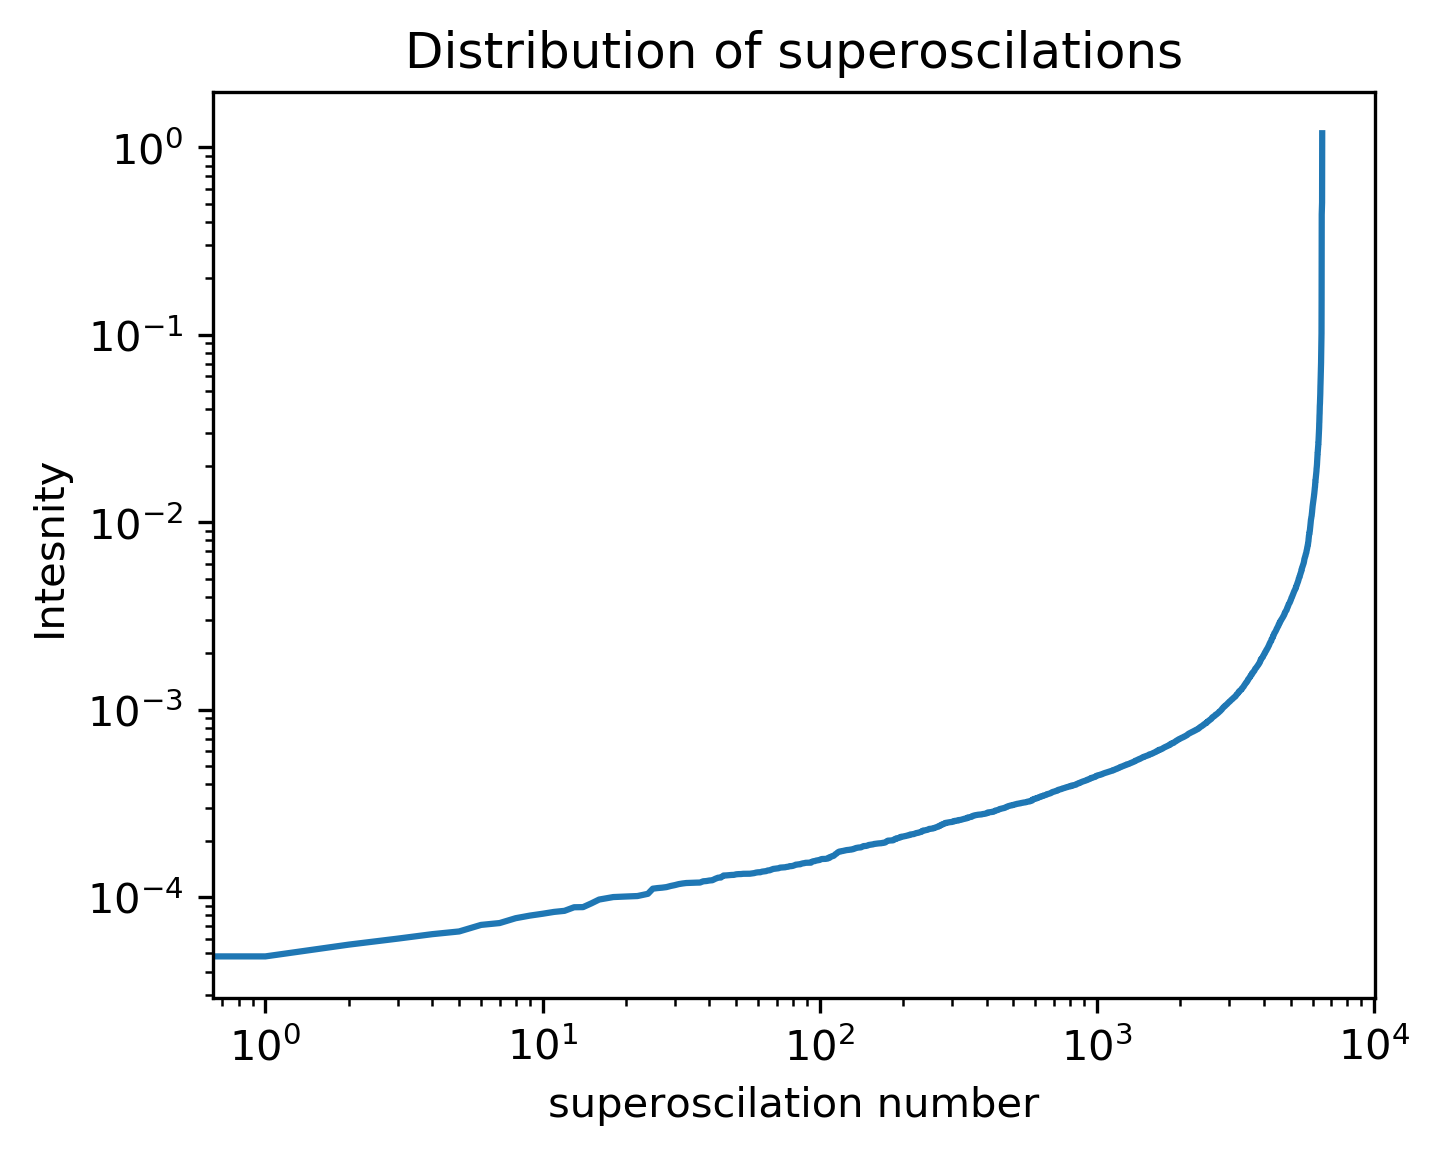

In [13]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(intensity_without_ampl_modulation)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

In [14]:
def get_err_combined_field(time_delays, time_window):
    return np.sqrt(sum(
        (_.err_upper_bound(time_window - delay) - _.err_lower_bound(time_window - delay) )** 2 
            for delay, _ in zip(time_delays, pulses.values())
    ))

In [15]:
def plot_predictions(all_time_delays):
    
    plt.figure(figsize=(10,4), dpi=300)
    plt.title("Best superoscilations")

    plt.subplot(121)

    long_time_window = 10 * time_window

    for n, time_delays in enumerate(all_time_delays[:3]):
        #plt.plot(long_time_window, get_combined_field(time_delays, long_time_window), label="theory {}".format(n))
        plt.errorbar(
            long_time_window, 
            get_combined_field(time_delays, long_time_window), 
            yerr = get_err_combined_field(time_delays, long_time_window),
            label="theory {}".format(n)
        )


    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. units)')
    plt.legend()

    plt.subplot(122)

    for n, time_delays in enumerate(all_time_delays[:3]):
        line = plt.plot(
            time_window, get_combined_field(time_delays, time_window), label="theory {}".format(n))
        line = line[0]

        # display raw points
        plt.errorbar(
            time_window_raw, 
            get_combined_field(time_delays, time_window_raw), 
            yerr = get_err_combined_field(time_delays, time_window_raw),
            color = line.get_color(),
            marker='*',
            linestyle=' ',
        )

    plt.gca().twinx().plot(
        time_window, 
        pulses[largest_freq].interp_field(time_window), 
        'k-',
        label=largest_freq,
    )
        
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. units)')
    plt.legend()

    plt.tight_layout()

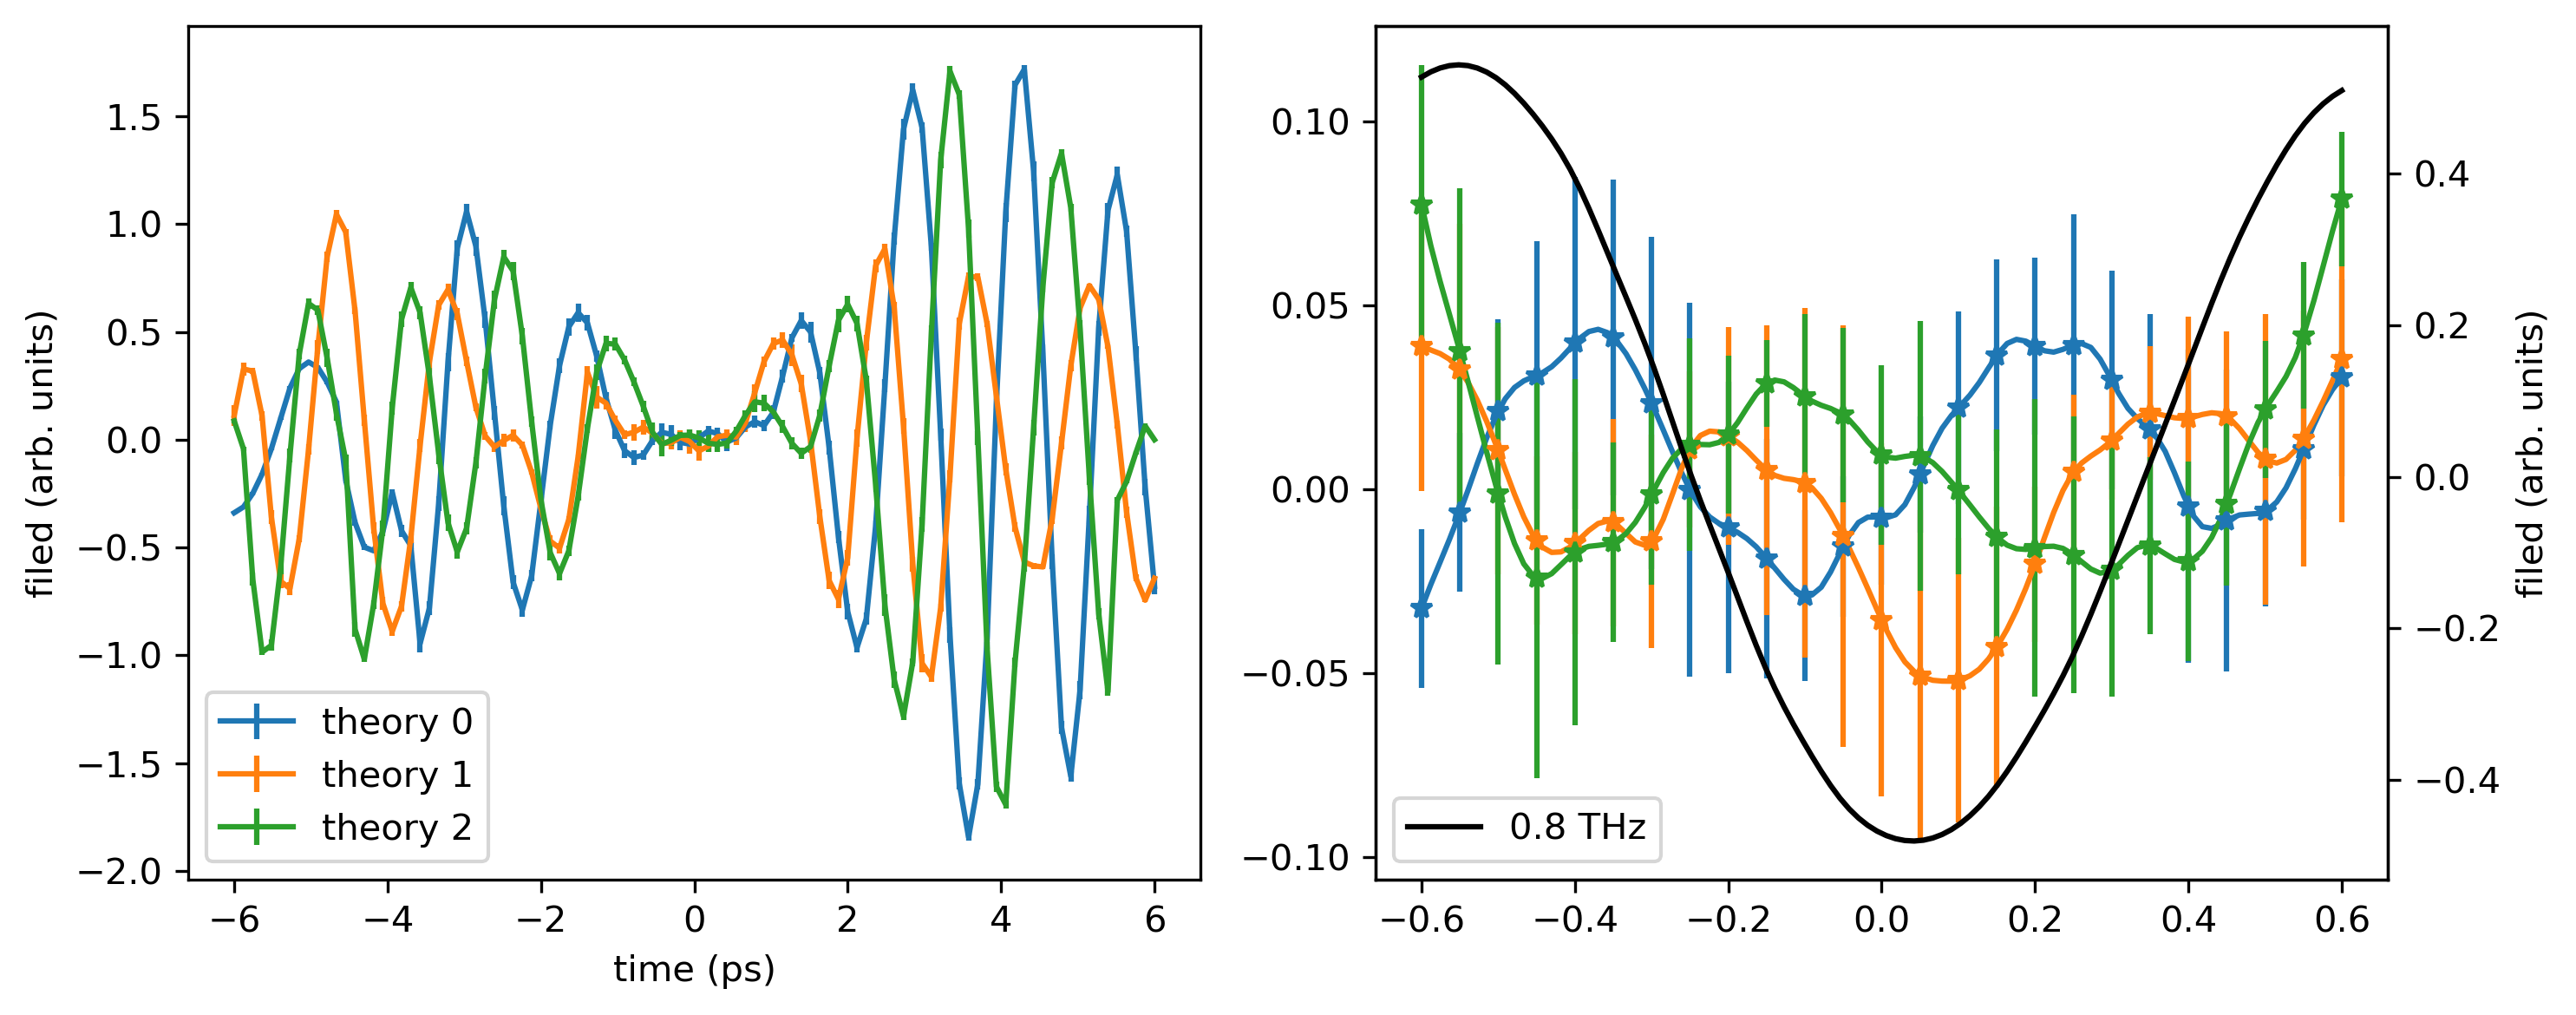

In [16]:
plot_predictions(all_time_delays[2000:2003])

plt.savefig(get_unique_filename("gradient_descent_so_{}.png"))

plt.show()  

In [17]:
np.array(all_time_delays[2000:2003])

array([[-1.09,  0.38,  1.36,  1.12],
       [-2.92, -0.55,  3.7 , -1.64],
       [-2.51,  0.89,  0.49, -0.84]])

## Comparing with experimental data

In [18]:
def load_experimental_so(file_template):
    
    # load file names matching the pattern
    filenames = sorted(glob.glob(folder_data + file_template))
    
    if len(filenames) == 0:
        # Nothing to load
        return
    
    all_data = [np.loadtxt(_).T[:-1] for _ in filenames]
    
    times, _individual_fields = zip(*all_data)
    
    _individual_fields = np.array(_individual_fields)
    
    time = times[0]
    
    # check that time is time
    assert np.all(np.diff(time) > 0), "`time` is probably not time"

    #  Checking whether the time axis coincide
    assert all(np.allclose(time, _) for _ in times), \
        "This workbook cannot be used since the time data is not syncronized"
    
    field = np.mean(_individual_fields, axis=0)
    
    # Substract the mean from experimental fields to compensate for parasitic offset
    field -= field.mean()
    
    # Saving the data 
    return Pulse(
        time = time, 
        field = field / max_ampl,
        _individual_fields = _individual_fields,
    )

Loading data

In [19]:
gradient_short_experimental_so = [load_experimental_so('/gradient_t{}_short_*.dat'.format(_)) for _ in range(3)]
gradient_short_experimental_so = [_ for _ in gradient_short_experimental_so if _]

gradient_long_experimental_so = [load_experimental_so('/gradient_t{}_long_*.dat'.format(_)) for _ in range(3)]
gradient_long_experimental_so = [_ for _ in gradient_long_experimental_so if _]

Plotting short and long measurement at the same time  

In [20]:
for long, short in zip(gradient_long_experimental_so, gradient_short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()

In [21]:
def plot_predictions_vs_experiment(all_time_delays, long_experimental_so, short_experimental_so):
    
    long_time_window = 10 * time_window

    data_plotting = list(zip(all_time_delays, long_experimental_so, short_experimental_so))
    n_plots = len(data_plotting)


    fig, axs = plt.subplots(n_plots, 2, figsize=(8, 2 * n_plots), dpi=300)


    for n, (time_delays, long, short,) in enumerate(data_plotting):


        #plt.title("Best superoscilations")

        axs[n, 0].plot(
            long_time_window, 
            get_combined_field(time_delays, long_time_window), 
            label="theory"
        )

        axs[n, 0].plot(long.time, long.field, '.', label="experiment")



        axs[n, 0].set_xlabel('time (ps)')
        axs[n, 0].set_ylabel('Electric filed (arb. u.)')


        axs[n, 1].plot(
            time_window, 
            get_combined_field(time_delays, time_window), 
            label=(None if n else "theory")
        )

        axs[n, 1].plot(short.time, short.field, '.', label="experiment")

        ax = axs[n, 1].twinx() 
        color = 'tab:green'

        ax.set_ylabel('Electric filed (arb. u.)', color=color)
        ax.plot(
            short.time, 
            pulses[largest_freq].interp_field(short.time - time_delays[-1]), 
            color=color,
            label=largest_freq,
        )
        ax.tick_params(axis='y', labelcolor=color)
        if n == 0:
            ax.legend()

    for ax in axs[:, 0]:
        ax.label_outer()

    for ax in axs[:-1, 1]:
        ax.set_xticklabels([])

    axs[-1, 1].set_xlabel('time (ps)')

    axs[0, 1].legend(loc='upper center')

    plt.tight_layout()
   

In [22]:
if gradient_long_experimental_so:
    plot_predictions_vs_experiment(all_time_delays, gradient_long_experimental_so, gradient_short_experimental_so)

    #plt.savefig(get_unique_filename("predicted_so_{}.png"))
    plt.show() 

# Calculate superoscillations via PEAK permutations

In [23]:
def permuation_analysis(kind):
    
    if kind == 'exhaustive posible':
        # all time delays
        all_time_delays = list(product(*[_.time_range for _ in pulses.values()]))
    elif kind == 'peaks only':
        all_time_delays = list(product(*[_.peaks_time for _ in pulses.values()]))
    else:
        raise ValueError("uknown kind of permutation analysis")
        
    # go through all possible time delays
    with Pool(cpu_count()) as pool:
        intensity_without_ampl_modulation = pool.map(inegral_without_ampl_modulation, tqdm(all_time_delays))
        
    # Extract the best candidates for getting superoscilations  
    intensity_without_ampl_modulation = np.array(intensity_without_ampl_modulation)
    indx = np.argsort(intensity_without_ampl_modulation)
    intensity_without_ampl_modulation = intensity_without_ampl_modulation[indx]

    all_time_delays = np.array(all_time_delays)[indx]
    
    return intensity_without_ampl_modulation, all_time_delays

In [24]:
permutation_peaks_intensity, permutation_peaks_time_delays = permuation_analysis('peaks only')

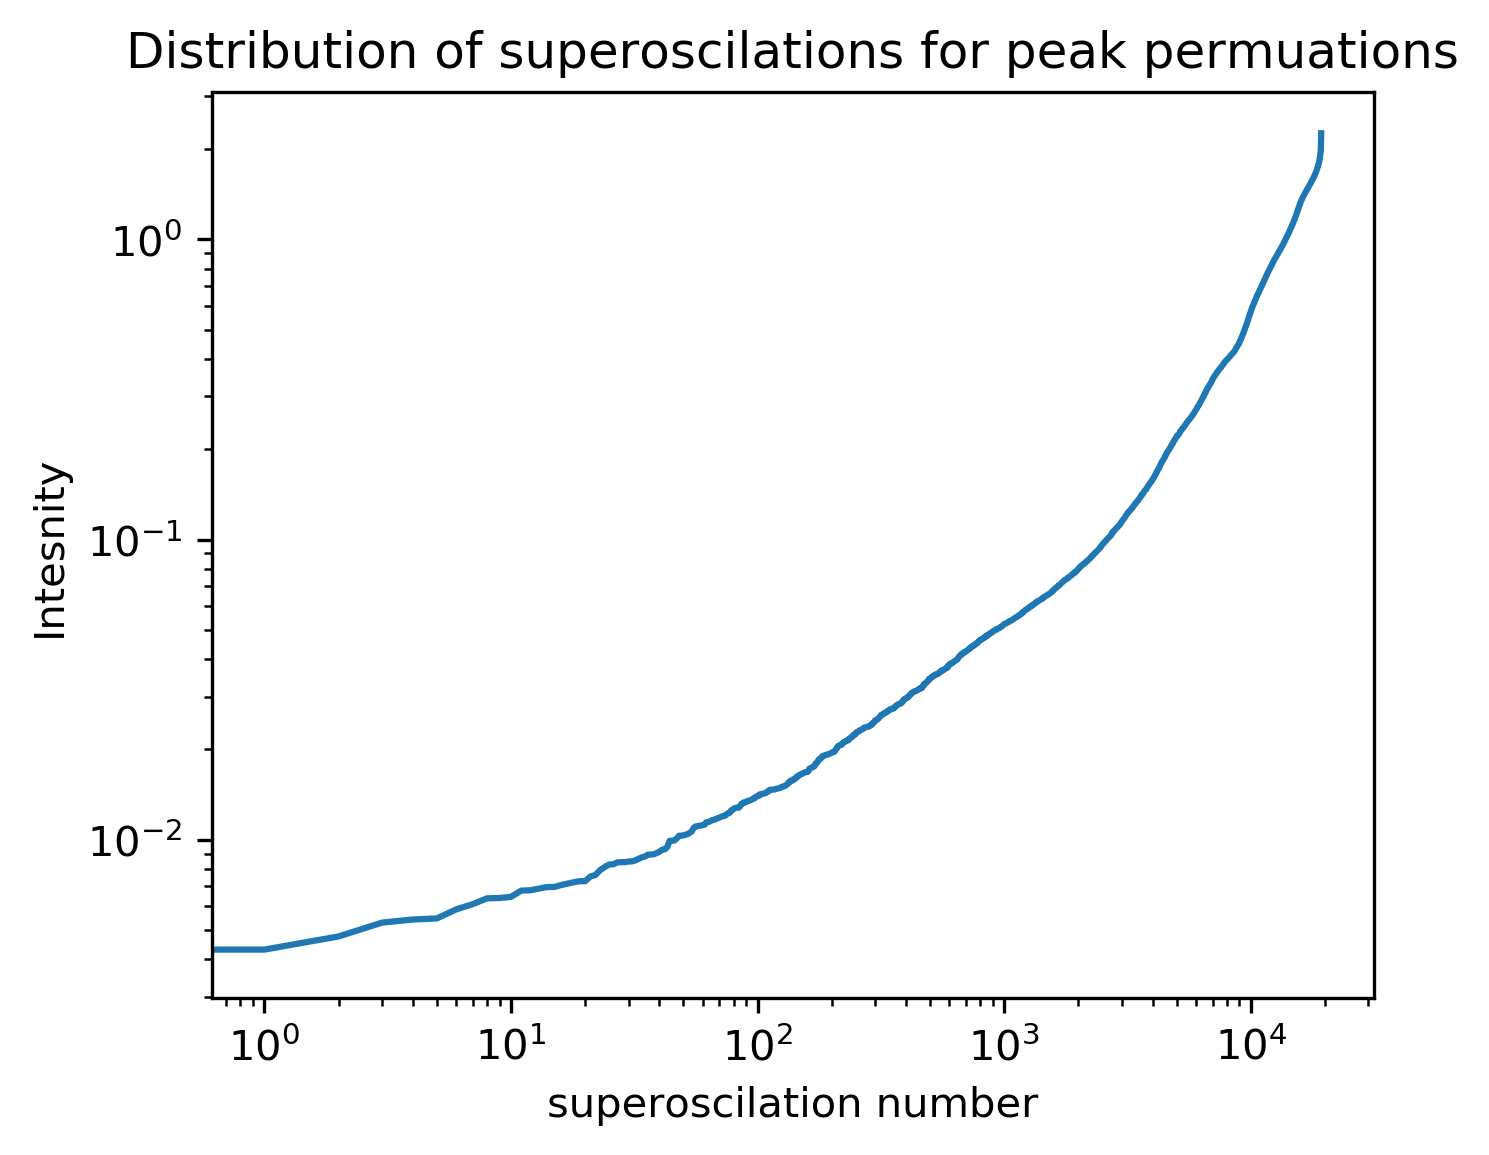

In [25]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations for peak permuations")
plt.loglog(permutation_peaks_intensity)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

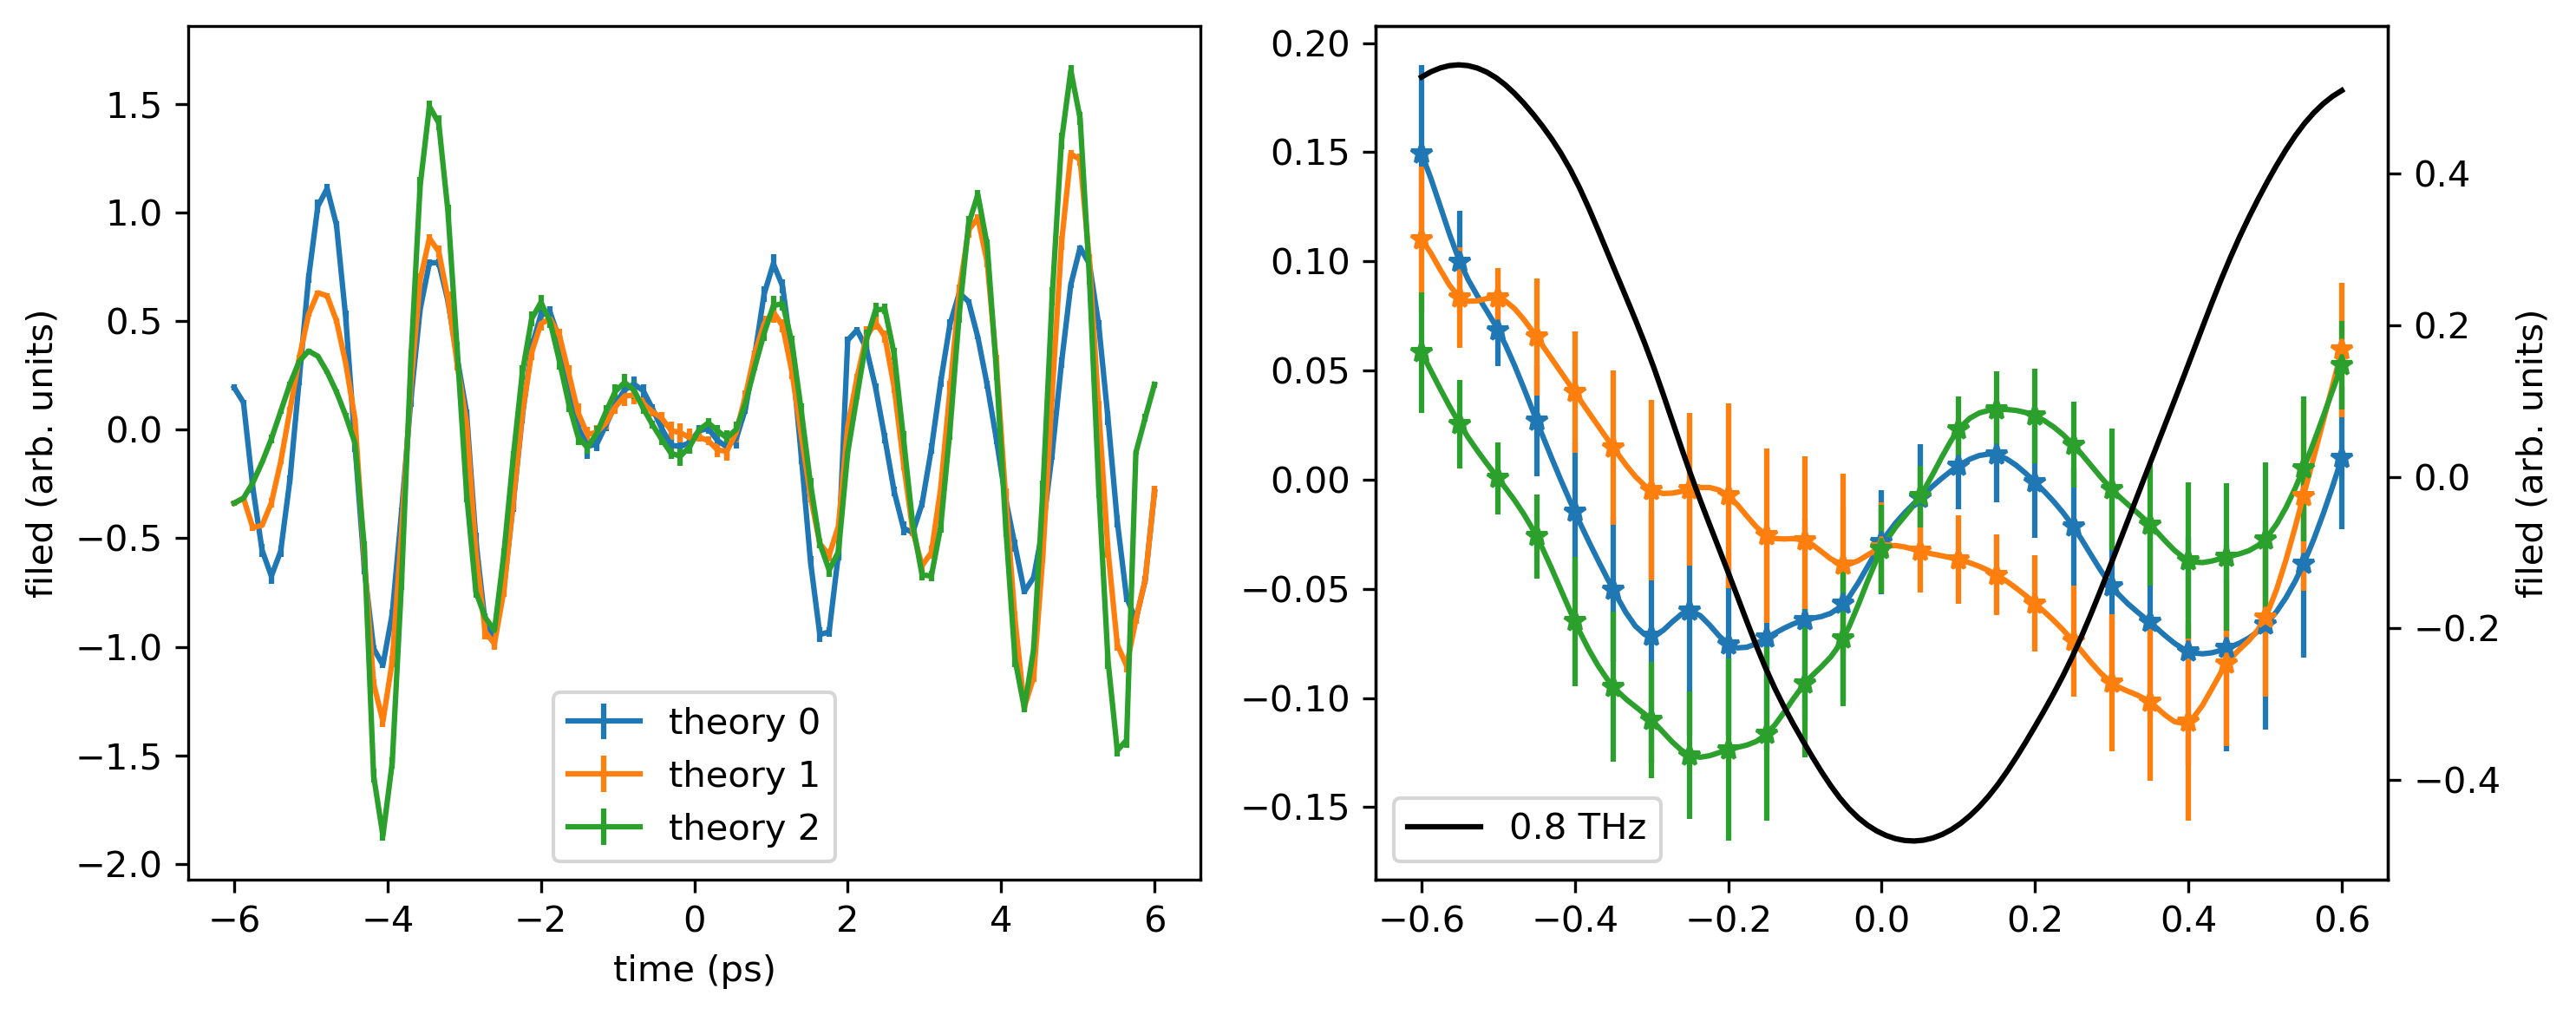

In [26]:
plot_predictions(permutation_peaks_time_delays)

plt.savefig(get_unique_filename("permutation_peak_{}.png"))

plt.show()  

In [27]:
permutation_peaks_time_delays[:3]

array([[-3.  , -0.8 ,  2.15, -3.  ],
       [-3.  , -0.8 ,  2.15,  0.65],
       [-3.  ,  2.3 ,  0.75,  0.65]])

## Comparing with experimental data

Loading data

In [28]:
peak_short_experimental_so = [load_experimental_so('/peak_t{}_short_*.dat'.format(_)) for _ in range(3)]
peak_short_experimental_so = [_ for _ in peak_short_experimental_so if _]

peak_long_experimental_so = [load_experimental_so('/peak_t{}_long_*.dat'.format(_)) for _ in range(3)]
peak_long_experimental_so = [_ for _ in peak_long_experimental_so if _]

Plotting short and long measurement at the same time

In [29]:
for long, short in zip(peak_long_experimental_so, peak_short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()

In [30]:
if peak_long_experimental_so:
    plot_predictions_vs_experiment(permutation_peaks_time_delays, peak_long_experimental_so, peak_short_experimental_so)

    #plt.savefig(get_unique_filename("predicted_so_{}.png"))
    plt.show() 

# Calculate superoscillations via exhaustive permutations

In [31]:
permutation_exhaustive_intensity, permutation_exhaustive_time_delays = permuation_analysis('exhaustive posible')

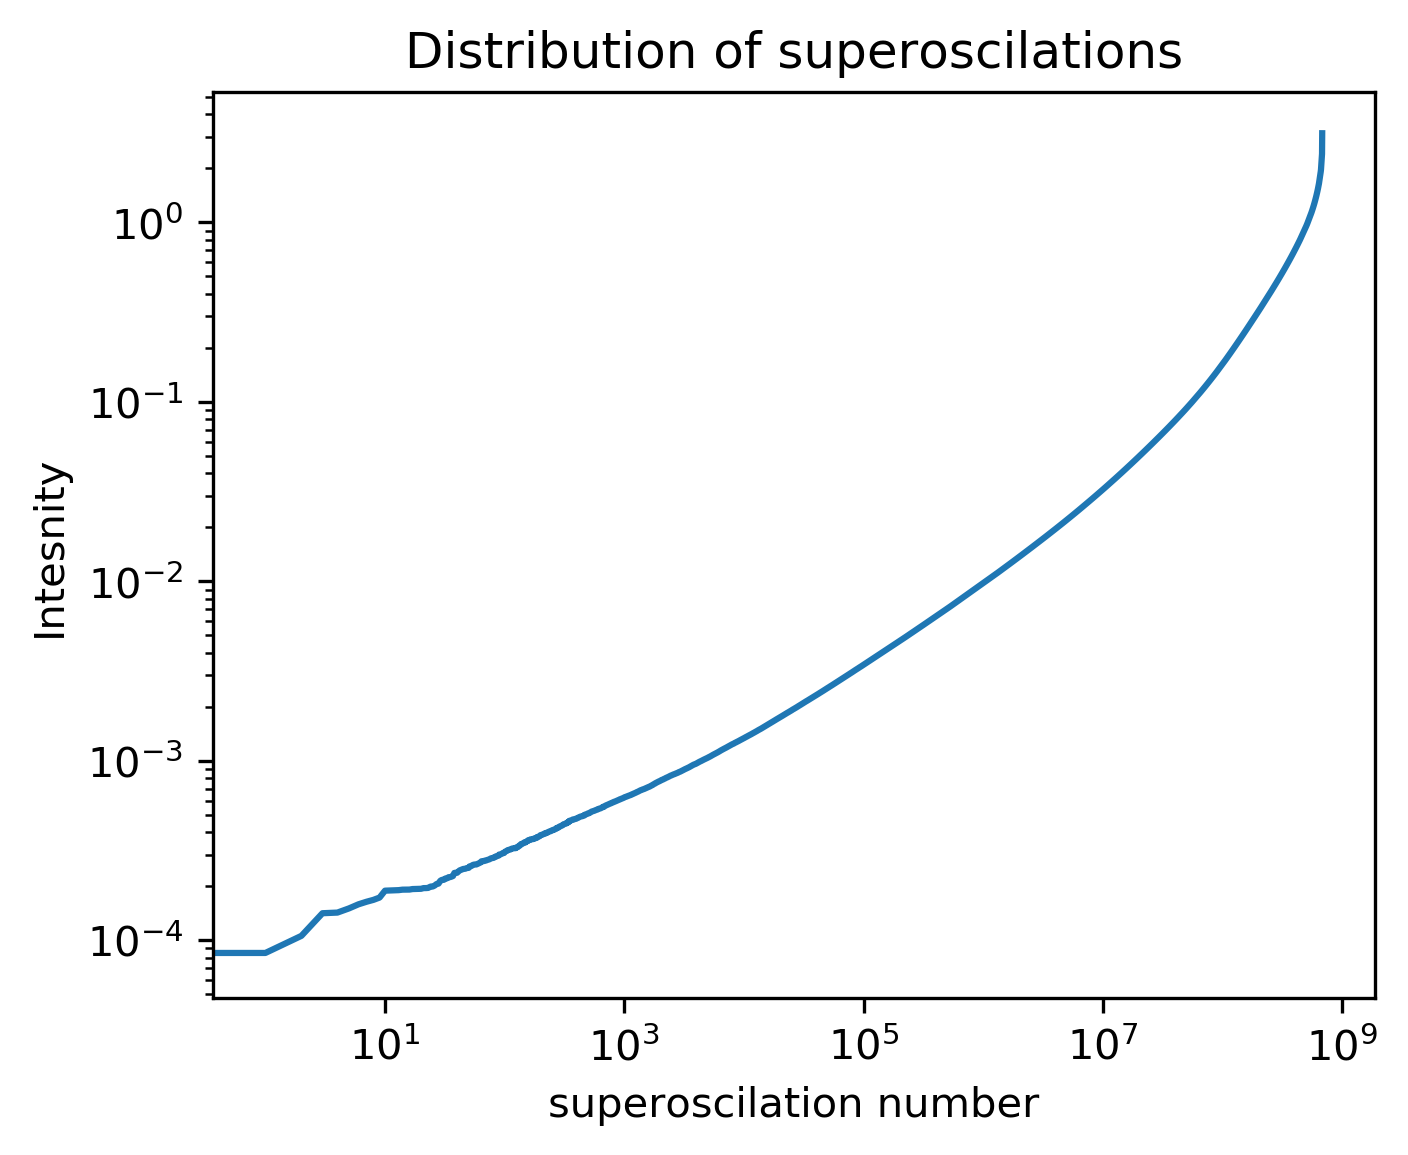

In [32]:
plt.figure(figsize=(5,4), dpi=300)
plt.title("Distribution of superoscilations")
plt.loglog(permutation_exhaustive_intensity)
plt.xlabel('superoscilation number')
plt.ylabel('Intesnity')
plt.show()

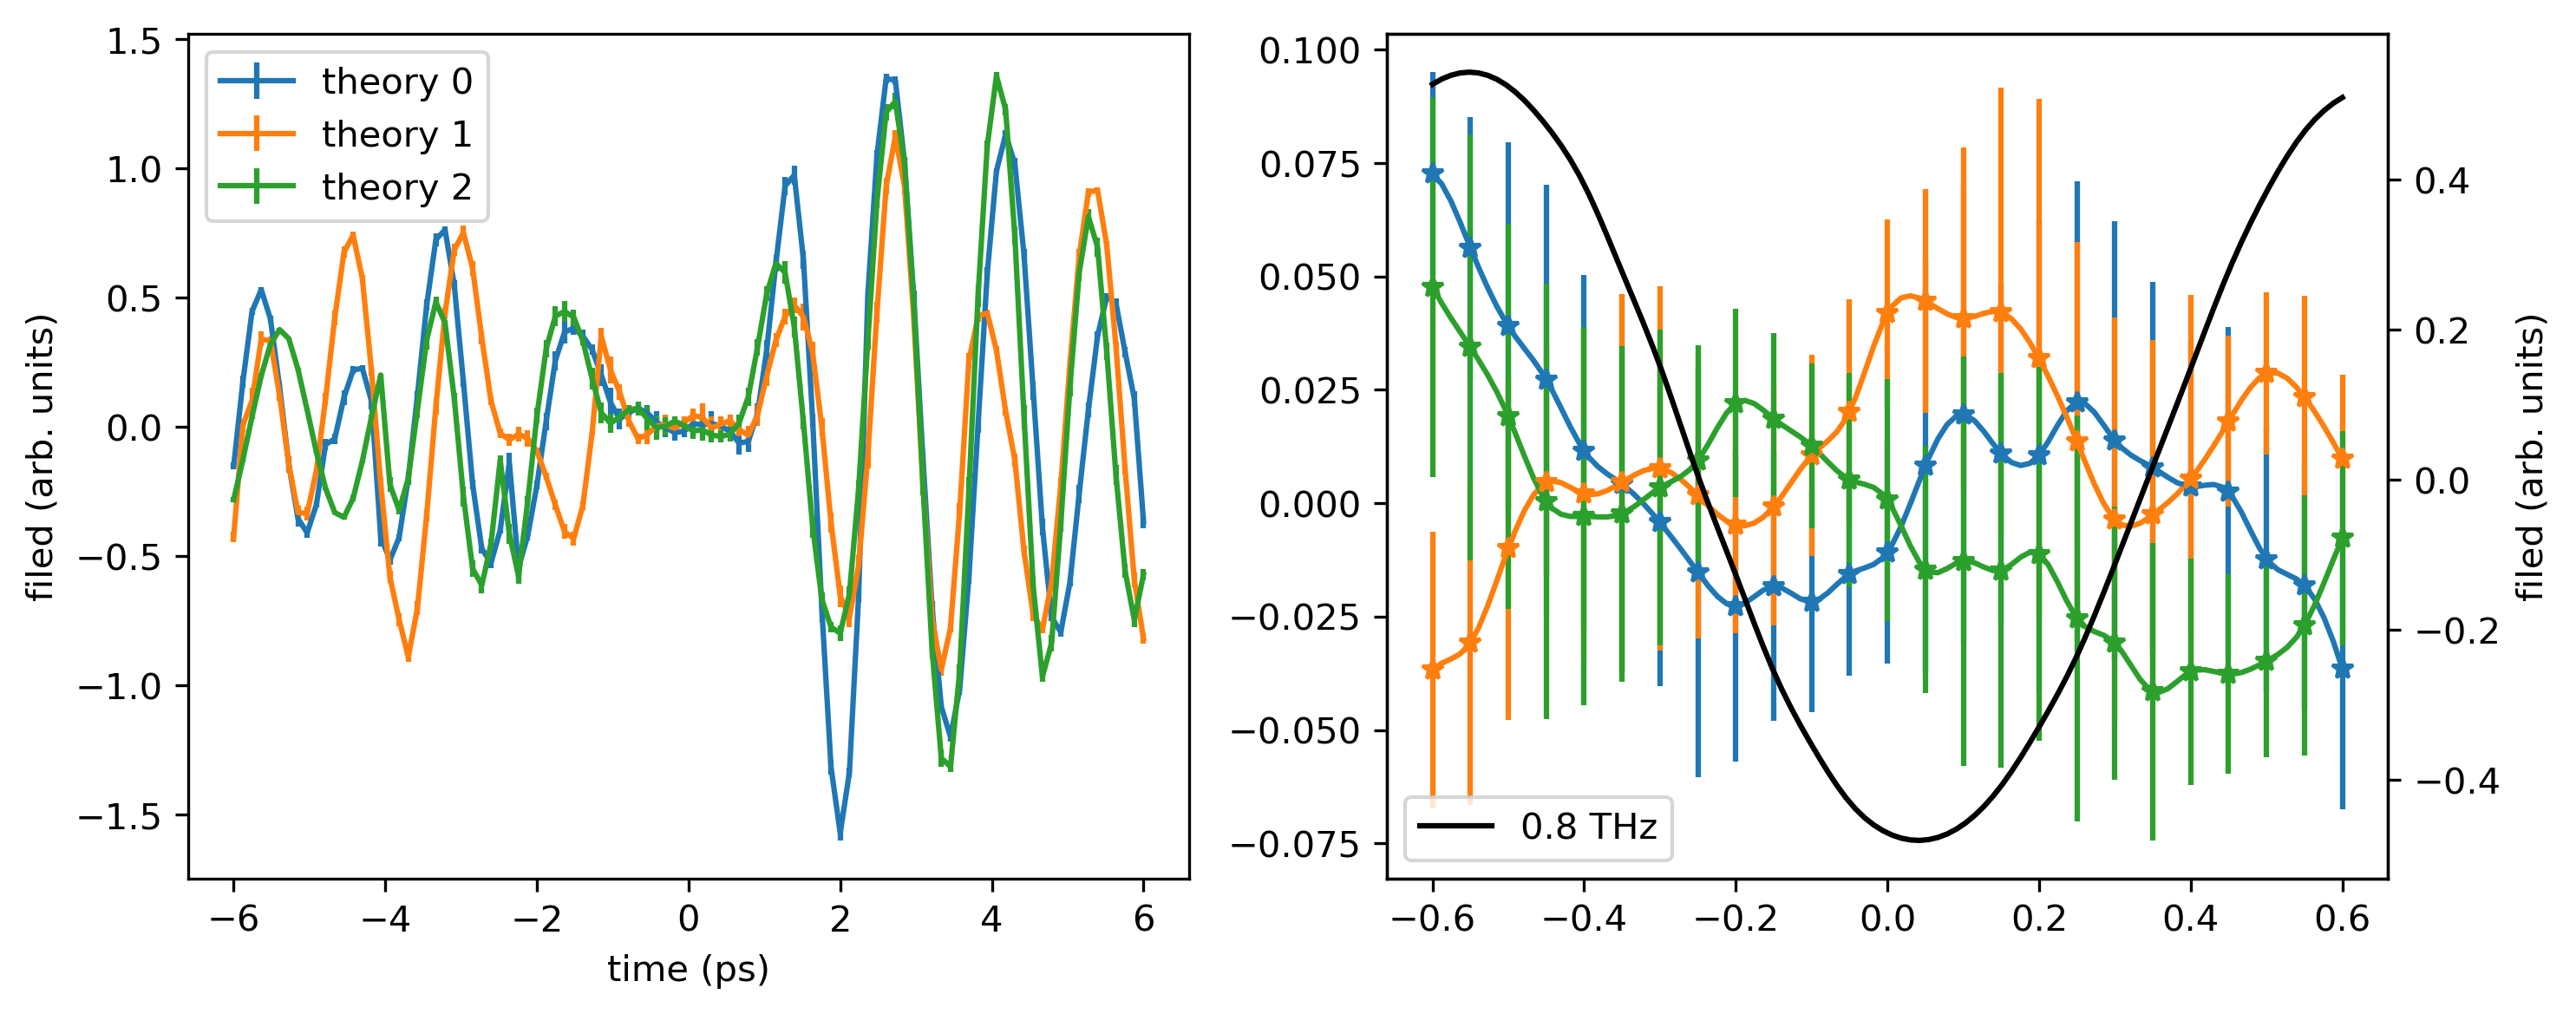

In [48]:
plot_predictions(permutation_exhaustive_time_delays[1000:1003])

plt.savefig(get_unique_filename("permutation_exhaustive_{}.png"))

plt.show()  

In [50]:
permutation_exhaustive_time_delays[1000:1003]

array([[ 0.85,  0.25,  2.65, -2.65],
       [-0.8 ,  1.25,  3.95, -1.4 ],
       [ 2.65, -3.  ,  2.55,  0.95]])

## Comparing with experimental data

Loading data

In [35]:
exhaustive_short_experimental_so = [load_experimental_so('/exhaustive_t{}_short_*.dat'.format(_)) for _ in range(3)]
exhaustive_short_experimental_so = [_ for _ in exhaustive_short_experimental_so if _]

exhaustive_long_experimental_so = [load_experimental_so('/exhaustive_t{}_long_*.dat'.format(_)) for _ in range(3)]
exhaustive_long_experimental_so = [_ for _ in exhaustive_long_experimental_so if _]

Plotting short and long measurement at the same time

In [36]:
for long, short in zip(exhaustive_long_experimental_so, exhaustive_short_experimental_so):
    plt.plot(long.time, max_ampl * long.field, '.')
    plt.plot(short.time, max_ampl * short.field, '.')
    plt.xlabel('time (ps)')
    plt.ylabel('filed (arb. u.)')
    plt.show()

In [37]:
if exhaustive_long_experimental_so:
    plot_predictions_vs_experiment(permutation_exhaustive_time_delays, exhaustive_long_experimental_so, exhaustive_short_experimental_so)

    #plt.savefig(get_unique_filename("predicted_so_{}.png"))
    plt.show() 